In [1]:
import cv2
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline

---
# Camera Calibration

In [2]:
def calibrate_camera(images, display=True):
    """
    """
    
    # board dimensions
    BOARD_X = 9
    BOARD_Y = 6
    
    # object = real undistorted grid
    objpoints = [] # 3D points IRL space
    imgpoints = [] # 2D points in image plane

    # looping through images to gather object and image points 
    for i in images:
        img = cv2.imread(i)
        # we need calibration images in grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # preparing object points
        # they all have  Z=0
        # so we only generate X,Y coordinates for OBJECT grid corners
        objp = np.zeros((BOARD_X * BOARD_Y, 3), np.float32)
        objp[:,:2] = np.mgrid[0:BOARD_X, 0:BOARD_Y].T.reshape(-1,2)

        # detecting chessboard corners in image
        ret, corners = cv2.findChessboardCorners(gray, (BOARD_X,BOARD_Y), None)

        # adding object and image points if corners are found
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)

            # drawing and displaying corners
            img_corners = cv2.drawChessboardCorners(img, (BOARD_X,BOARD_Y), corners, ret)
            if display:
                plt.figure()
                plt.imshow(img_corners)
    
    # time to actually calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    if ret:
        return mtx, dist
    return None,None

In [3]:
# pickle !!

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')

cam_mtx, cam_dist = calibrate_camera(images, False)

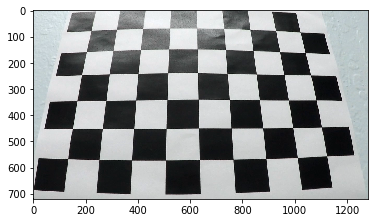

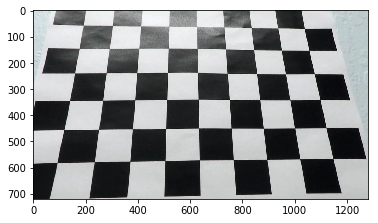

In [5]:
from random import randint 
i = images[randint(0,20)]
img = cv2.imread(i)
dst = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
plt.imshow(img)
plt.figure()
plt.imshow(dst)    

---
# Pipeline
## Distortion Correction

## Gradient Thresholds

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    direction = (1,0) if orient=='x' else (0,1)
    sobel = cv2.Sobel(gray, cv2.CV_64F, direction[0], direction[1])
    
    # Calculate directional gradient
    sobel_abs = np.absolute(sobel)
    sobel_norm = np.uint8(255*sobel_abs / np.max(sobel_abs))
    
    # Apply threshold
    grad_binary = np.zeros_like(sobel_norm)
    #grad_binary[(sobel_norm > thresh_min) & (sobel_norm < thresh_max)] = 1
    grad_binary[(sobel_norm > thresh[0]) & (sobel_norm < thresh[1])] = 1
    
    return grad_binary

In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate gradient magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag_norm = np.uint8(255*mag/np.max(mag))
    
    # Apply threshold
    mag_binary = np.zeros_like(mag_norm)
    mag_binary[(mag_norm >= mag_thresh[0]) & (mag_norm <= mag_thresh[1])] = 1
    
    return mag_binary

In [8]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Calculate gradient direction
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

In [9]:
image = mpimg.imread('test_images/test1.jpg')

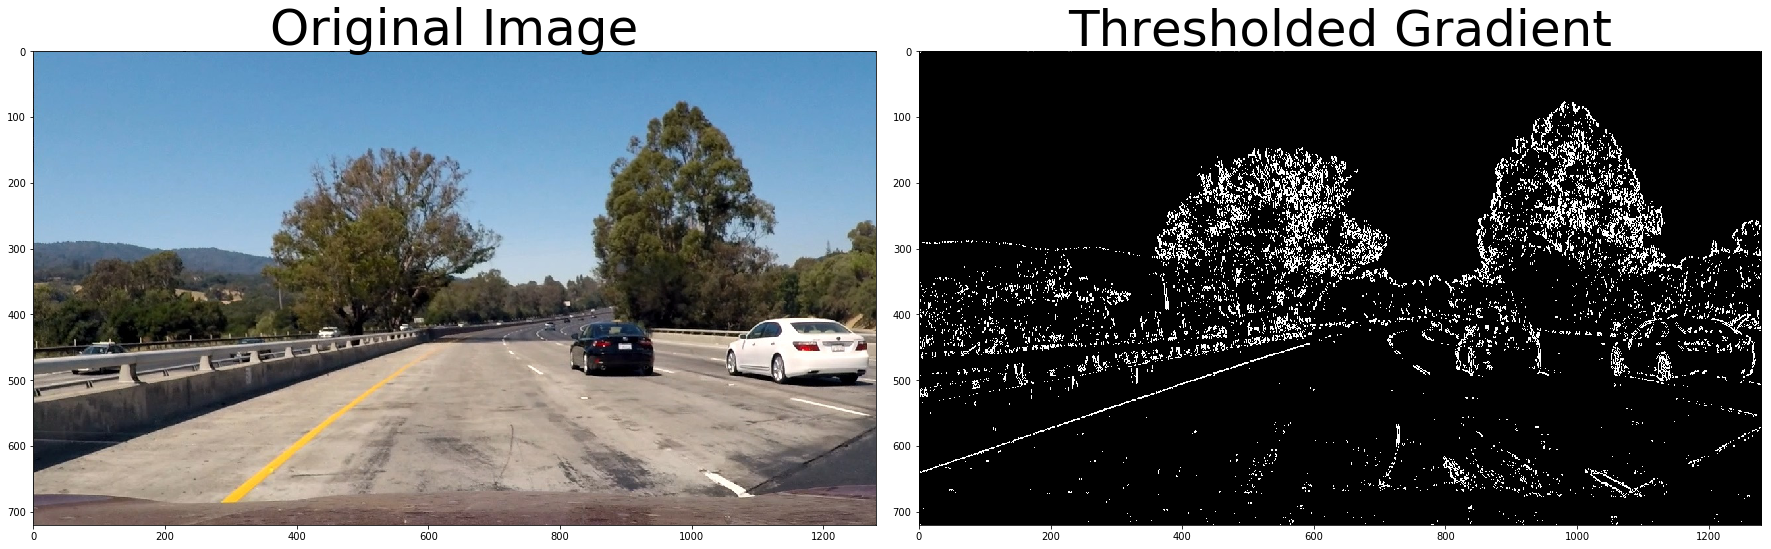

In [10]:
grad_binary_x = abs_sobel_thresh(image, orient='x', thresh=(20,100))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

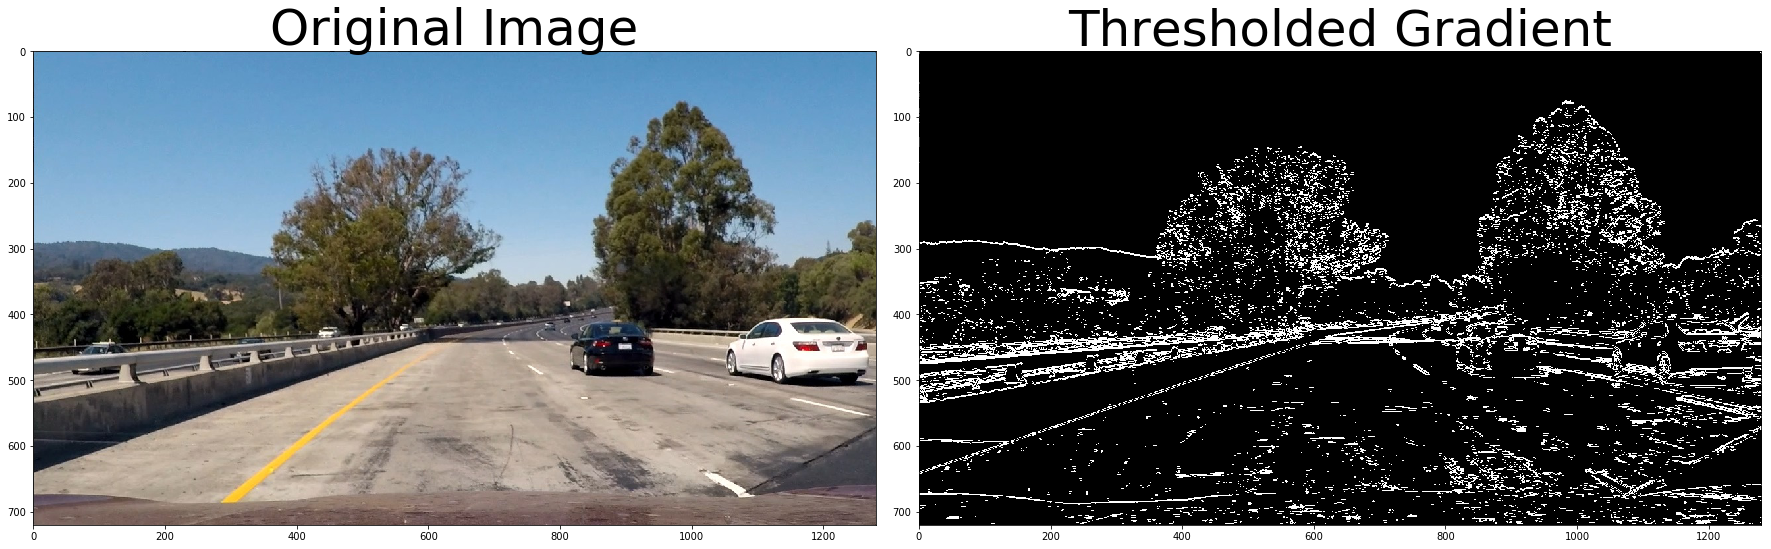

In [11]:
grad_binary_y = abs_sobel_thresh(image, orient='y', thresh=(20,100))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_y, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

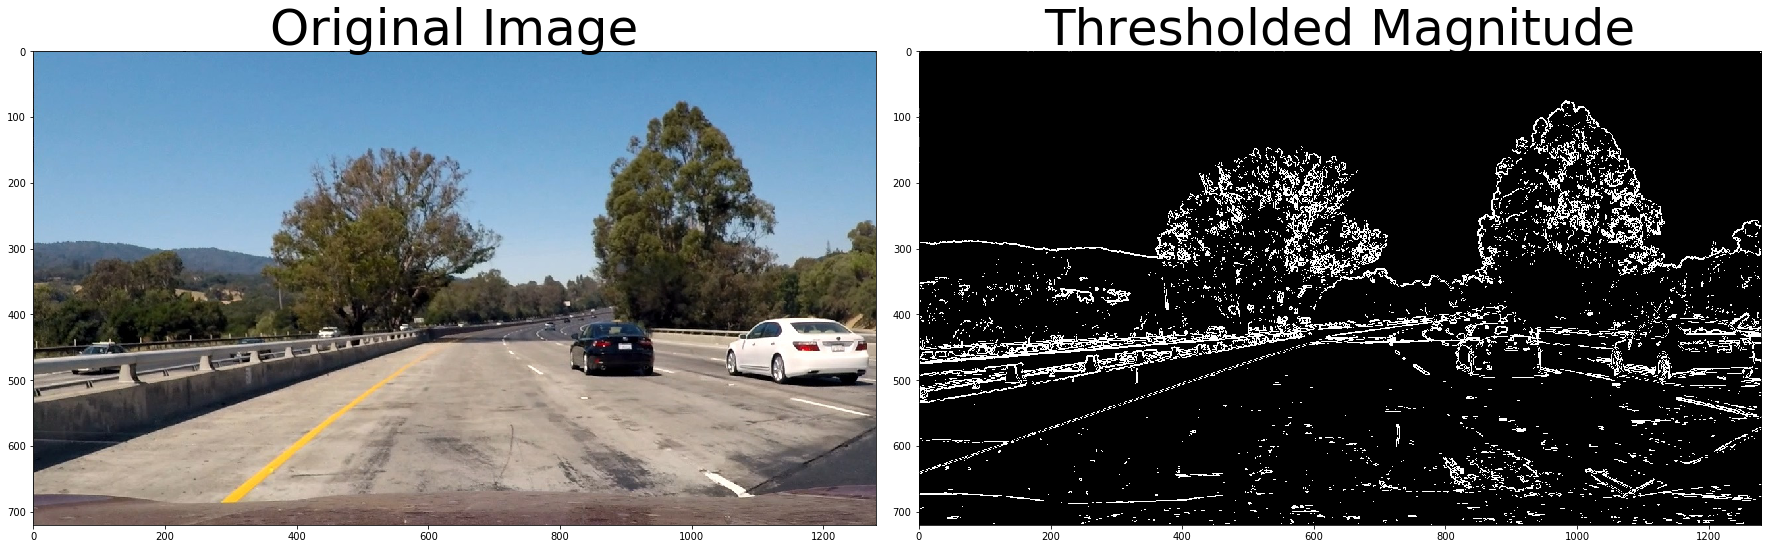

In [12]:
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

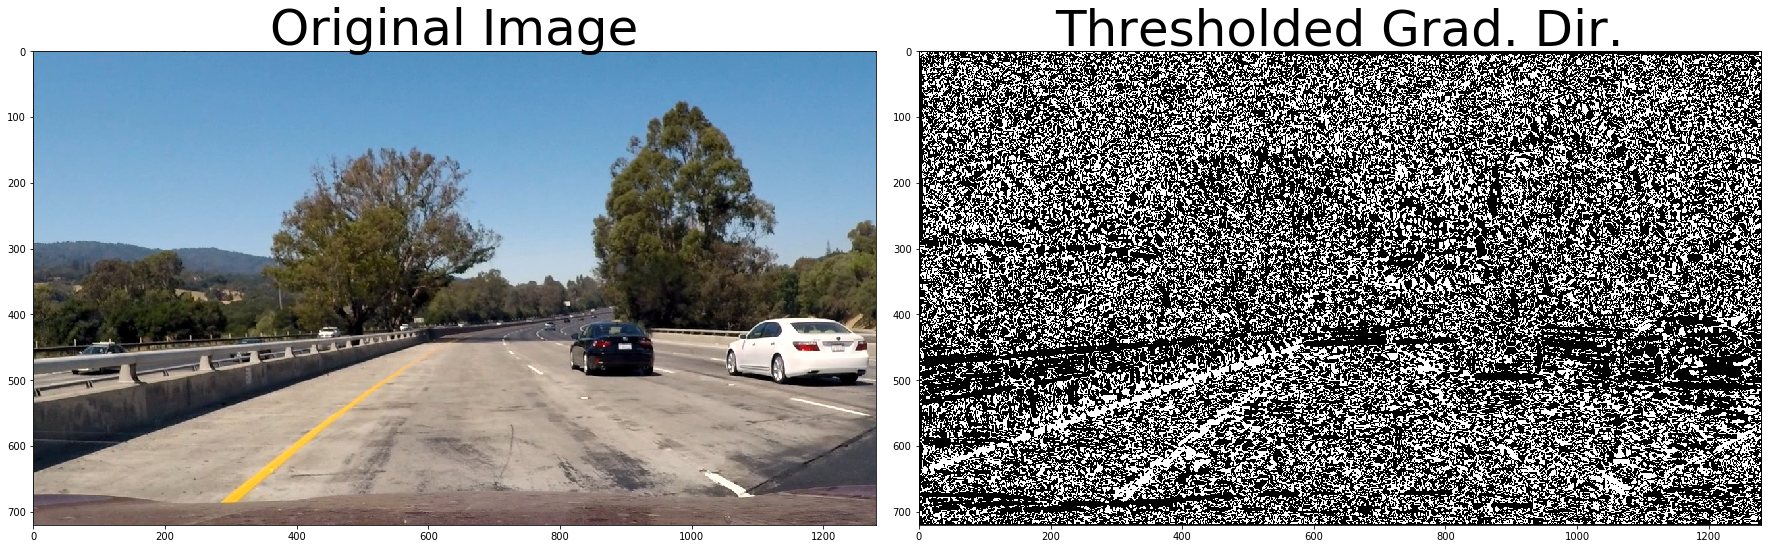

In [13]:
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

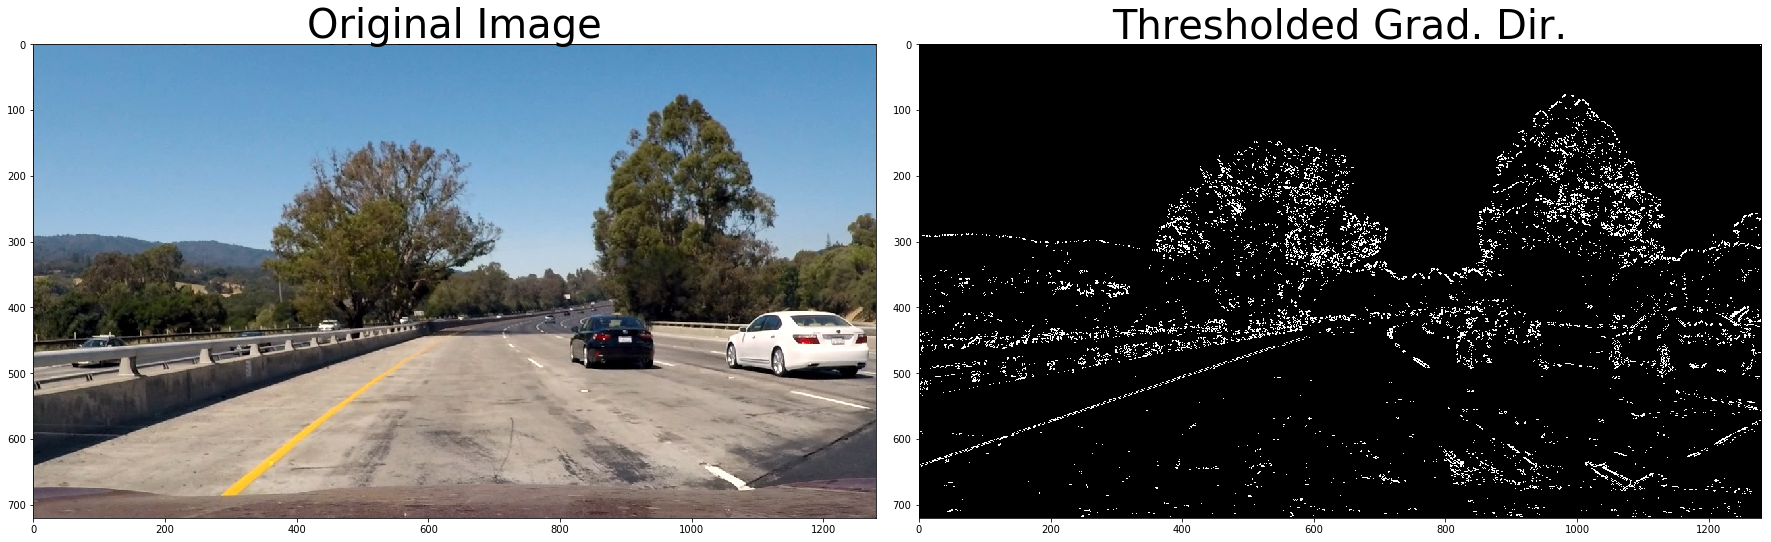

In [14]:
combined = np.zeros_like(dir_binary)
combined[((grad_binary_x == 1) & (grad_binary_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

 ---
 ## Color Thresholds
 ### RGB

In [15]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

In [16]:
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

### HLS

In [17]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

In [18]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

In [19]:
# faut faire une autre fonction et tout.. channel en param, une pr rgb et autre pr hls

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    # 2) Apply a threshold to the S channel
    mask = np.zeros_like(s)
    mask[(s > thresh[0]) & (s <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    binary_output = np.copy(img) # placeholder line
    return mask
    
hls_binary = hls_select(image, thresh=(30, 100))

## Perspective Transform

In [20]:
# find 4 points => decent trapezoid on straight lane image

In [21]:
image = mpimg.imread('test_images/straight_lines1.jpg')

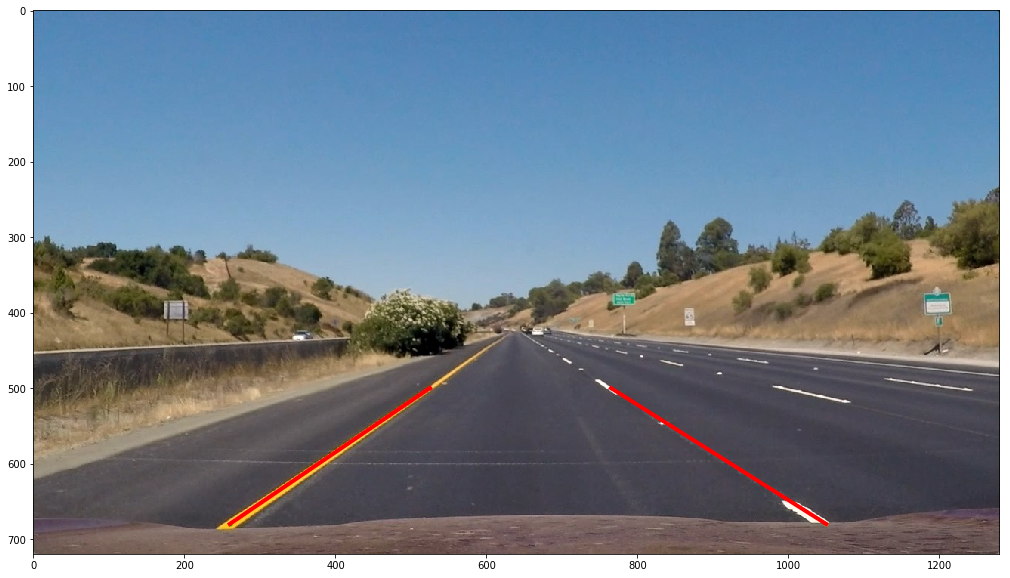

In [22]:
plt.figure(figsize=(25,10))
plt.imshow(image)

src_TR = [765, 500]
src_BR = [1050, 680]
src_BL = [260, 680]
src_TL = [525, 500]

dst_TR = [1000, 200]
dst_BR = [1000, 700]
dst_BL = [300, 700]
dst_TL = [300, 200]

plt.plot(src_TR[0], src_TR[1], '.') # top right
plt.plot(src_BR[0], src_BR[1], '.') # bottom right
plt.plot(src_BL[0], src_BL[1], '.') # bottom left
plt.plot(src_TL[0], src_TL[1], '.') # top left

plt.plot([src_TR[0], src_BR[0]], [src_TR[1], src_BR[1]], color='r', linestyle='-', linewidth=4)
plt.plot([src_TL[0], src_BL[0]], [src_TL[1], src_BL[1]], color='r', linestyle='-', linewidth=4)



In [23]:
def warp(img):
    size = (img.shape[1], img.shape[0]) # !!! must invert for some reason
    src = np.float32([src_TR,src_BR,src_BL,src_TL])
    dst = np.float32([dst_TR,dst_BR,dst_BL,dst_TL])
    
    # perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # inverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # warping image using linear interpolation
    warped = cv2.warpPerspective(img, M, size, flags=cv2.INTER_LINEAR)
    
    return warped

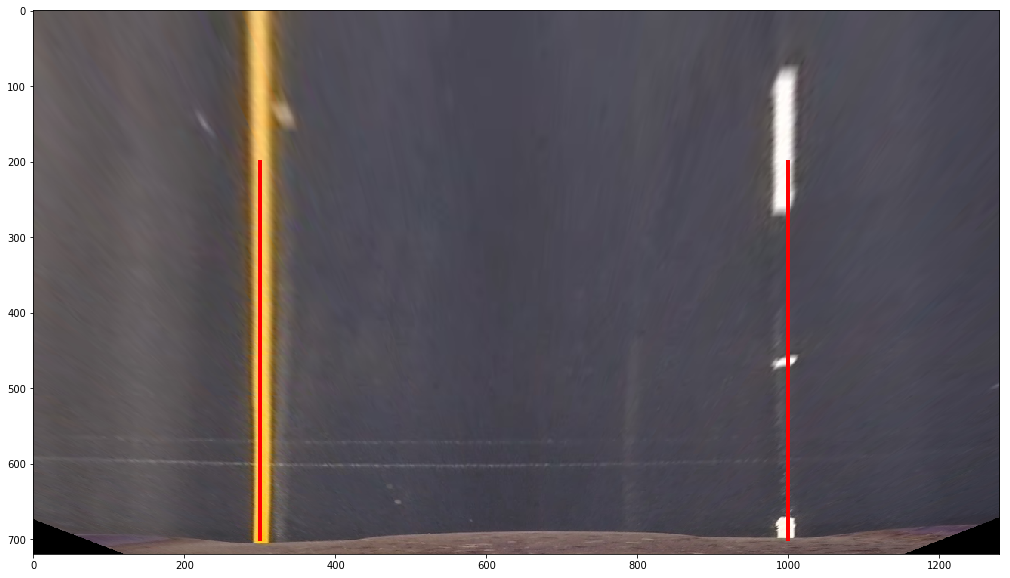

In [24]:
w = warp(image)
plt.figure(figsize=(25,10))
plt.imshow(w)

plt.plot([dst_TR[0], dst_BR[0]], [dst_TR[1], dst_BR[1]], color='r', linestyle='-', linewidth=4)
plt.plot([dst_TL[0], dst_BL[0]], [dst_TL[1], dst_BL[1]], color='r', linestyle='-', linewidth=4)

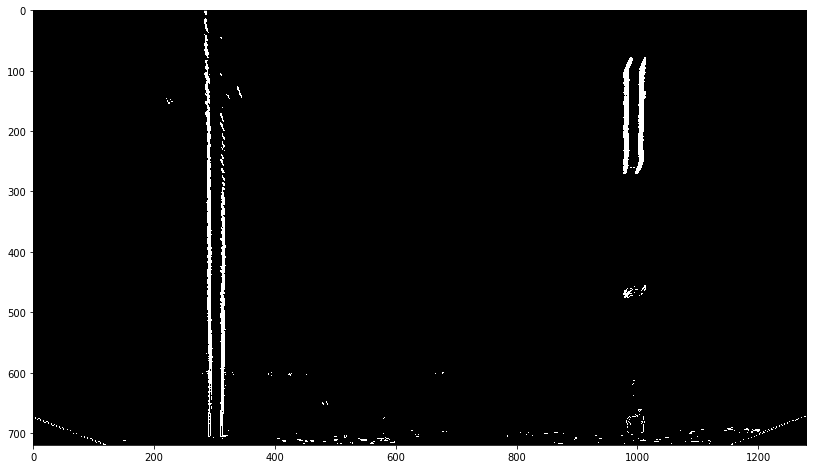

In [25]:
# warped image
w
mag_b = mag_thresh(w, sobel_kernel=3, mag_thresh=(30, 100))
dir_b = dir_threshold(w, sobel_kernel=15, thresh=(0.7, 1.3))
gradx_b = abs_sobel_thresh(w, orient='x', thresh=(20,100))
grady_b = abs_sobel_thresh(w, orient='y', thresh=(20,100))
hls_b = hls_select(w, thresh=(30, 110))

cmb = np.zeros_like(mag_b)
cmb[((gradx_b == 1) & (mag_b == 1)) | ((mag_b == 1) & (hls_b == 1))] = 1

plt.figure(figsize=(20,8))
plt.imshow(cmb, cmap='gray')

img_bin = cmb

---
# Lane Finding
### Histogram Peaks

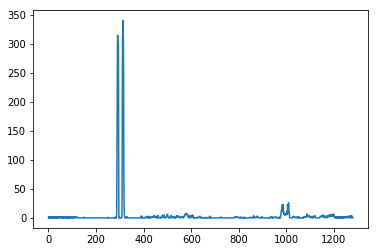

In [26]:
# collapsing pixel intensities on x axis
histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Sliding Window Search

In [35]:
# locating the peak in each half to base the windows
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# image for displaying results
out_img = np.dstack((img_bin,img_bin,img_bin)) * 255

# sliding window properties
nwindows = 9
window_height = np.int(img_bin.shape[0]/nwindows)

# isolating active pixels
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [36]:
leftx_current = leftx_base
rightx_current = rightx_base

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

In [37]:
for window in range(nwindows):
    # window boundaries
    win_y_low = img_bin.shape[0] - (window+1)*window_height
    win_y_high = img_bin.shape[0] - window*window_height
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # draw windows
    cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
    cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
    
    # isolating active pixels within windows
    good_left_inds = (
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)
    ).nonzero()[0]
    
    good_right_inds = (
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)
    ).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # recenter next window on mean position if enough active pixels are found in current one
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    

In [38]:
# preparing coordinates of all active pixels within windows
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]

rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# fitting a second order polynomial to each set of active pixels
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

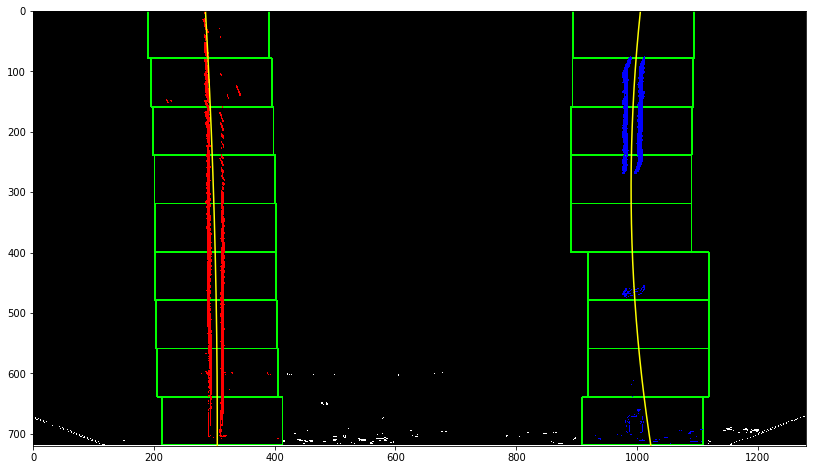

In [39]:
# viz
# Generate x and y values for plotting
ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(20,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Measuring Curvature

---
# Image Pipeline

---
# Video Pipeline